### Initial data exploration of public stock market data provided for the PDX Stock Market Analysis Workgroup

#### Members: 
- John Burt
- Sonny Nallamilli
- Matt Leffers
- Robert Lugg
- Purbasha Chatterjee
- Manish Kumar Saraf

Workgroup Slack channel:
https://pdxdsworkgroup.slack.com


Note: this code assumes that data files are located in same folder as notebook

data files:

http://dive-into.info/2149/stocks-us-adjClose.csv

http://dive-into.info/2149/stocks-us-moreData.zip

- Set up plot environment.
- Load stock market data from csv into pandas dataframe

In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 100
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np

pd.options.display.max_rows = 100

#*********************************************************
#Two datasets are available: a training set and a test set. 
#We'll be using the training set to build our predictive model 
#and the testing set to score it and generate an output file to 
#submit on the Kaggle evaluation system.

# load the basic stock market value dataset, set date (col 0) as index
data = pd.read_csv('stocks-us-adjClose.csv', index_col=0)

# look at what we got:
#data.shape
#data.head()
#data.describe()

Function to compute stock growth rate for each value in a time series.
- dates = dates, in datetime format and matched with stock values
- values = stock values
- past_interval = time interval in the past to compare given stock value against.
- smoothing_interval = number of samples in the past to use to estimate past stock value. For smoothing, I use a median here, because it is less sensitive to outliers.

In [2]:
def stock_growth_rate(dates, values, past_interval=365, smoothing_interval=1):

    rateslen = values.shape[0]-past_interval
    smoothing_int_d2 = int(smoothing_interval/2)
    rates = np.zeros((rateslen,))   
    
    # don't use smoothing (save some time)
    if smoothing_interval <= 1:
        for i in range(rateslen):
            rates[i] = ((values[i+past_interval] / values[i]) - 1) * 100

    # use smoothing
    else:
        for i in range(rateslen):
            # ensure smoothing interval is centered around past interval time 
            smoothstart = i-smoothing_int_d2 
            if smoothstart<0: smoothstart=0 # oops, out of range
            rates[i] = ((values[i+past_interval] / values[smoothstart:i+smoothing_int_d2].median()) - 1) * 100
    
    return dates[past_interval:], rates
        

Functions to plot stock growth rates

In [138]:
from scipy.interpolate import interp1d

# Annoyingly, there isn't an easy way to plot a line graph with green above and red below a threshold y value, so I made one here
def plot_with_colored_y_thresh(ax, x, y, threshold=0, hicolor="g", lowcolor="r", **kwargs):
    
    hi_line = []
    lo_line = []
    
    linecolor = hicolor
    hi = True
    if y[0] < threshold:
        linecolor = lowcolor
        hi = False

    starti = 0
    i = 1
    # scan through y data, use threshold crossings to break plots into segments 
    while i < y.shape[0]:
        # hi to lo threshold cross
        if hi and y[i] < threshold:
            # draw the hi lines
            hi_line, = ax.plot(x[starti:i+1], y[starti:i+1], c=linecolor, **kwargs)
            # split the last line at the threshold cross
            datenums = matplotlib.dates.date2num(x[i-1:i+1].to_pydatetime())
            # use interpolation to split threshold crossing lines into hi and lo color portions.
            f = interp1d(y[i-1:i+1], datenums)
            x0 = matplotlib.dates.num2date(f(0))
            # draw the hi to thresh line
            ax.plot([x[i-1],x0], [y[i-1],0], c=linecolor, **kwargs)
            # draw the thresh to lo line
            linecolor = lowcolor # next line will be low color
            ax.plot([x0,x[i]], [0,y[i]], c=linecolor, **kwargs)
            hi = False
            starti = i
        # lo to hi threshold cross
        elif not hi and y[i] >= threshold:
            lo_line, = ax.plot(x[starti:i+1], y[starti:i+1], c=linecolor, **kwargs)
            # split the last line at the threshold cross
            datenums = matplotlib.dates.date2num(x[i-1:i+1].to_pydatetime())
            # use interpolation to split threshold crossing lines into hi and lo color portions.
            f = interp1d(y[i-1:i+1], datenums)
            x0 = matplotlib.dates.num2date(f(0))
            # draw the hi to thresh line
            #ax.plot([x[i-1],xinterp], [y[i-1],0], c=linecolor, **kwargs)
            ax.plot([x[i-1],x0], [y[i-1],0], c=linecolor, **kwargs)
            # draw the thresh to lo line
            linecolor = hicolor # next line will be hi color
            ax.plot([x0,x[i]], [0,y[i]], c=linecolor, **kwargs)
            hi = True
            starti = i
        i += 1
    # plot the last segment of data
    if starti != i:
        i = y.shape[0]
        li, = ax.plot(x[starti:i+2], y[starti:i+2], c=linecolor, **kwargs)
        if linecolor == hicolor:
            hi_line = li
        else:
            lo_line = li
    return hi_line, lo_line

# Given dates and stock values, plot combined graph of stock values and stock growth rate (RE past_interval)
# Uses my fancy threshold plot function to draw different colored lines above (green) and below (red) zero
def plot_growth_rate(dates, values, past_interval=365, smoothing_interval=1):
    
    # calculate stock growth rate
    growthrate_x, growthrate = stock_growth_rate(dates, values, past_interval, smoothing_interval)

    # create two subplot axes to allow overlaid graphs with different y axis scales
    fig, ax1 = plt.subplots(figsize=(20, 10))
    ax2 = ax1.twinx()

    # plot mean stock value
    color = "blue"
    value_line, = ax1.plot(dates, values, "-b", linewidth=1, label="Stock value")
    ax1.set_xlabel('date')
    ax1.set_ylabel('stock value')
    ax1.yaxis.grid(b=None)
    for t in ax1.get_yticklabels():
        t.set_color(color)

    # adjust the x axis year labels
    a = plt.xticks(matplotlib.dates.YearLocator(base=1, month=1, day=1).tick_values(min(dates), max(dates)), rotation='vertical')
    
    hi_line, lo_line = plot_with_colored_y_thresh(ax2, growthrate_x, growthrate, linewidth=1 )
    color = "green"
    ax2.set_ylabel('% growth rate')
    for t in ax2.get_yticklabels():
        t.set_color(color)
       
    ax1.legend([value_line, hi_line, lo_line],
               ["Stock value","Positive stock growth RE %d days prior"%(past_interval),
                "Negative stock growth RE %d days prior"%(past_interval)])

    fig.autofmt_xdate()
    
    plt.show()

In [55]:
# combine all stock to create a yearly mean
allstockmean = data.mean(axis=1)
allstockmean_dates = pd.to_datetime(data.index) 


plot growth rate RE one year in past, with a little smoothing:

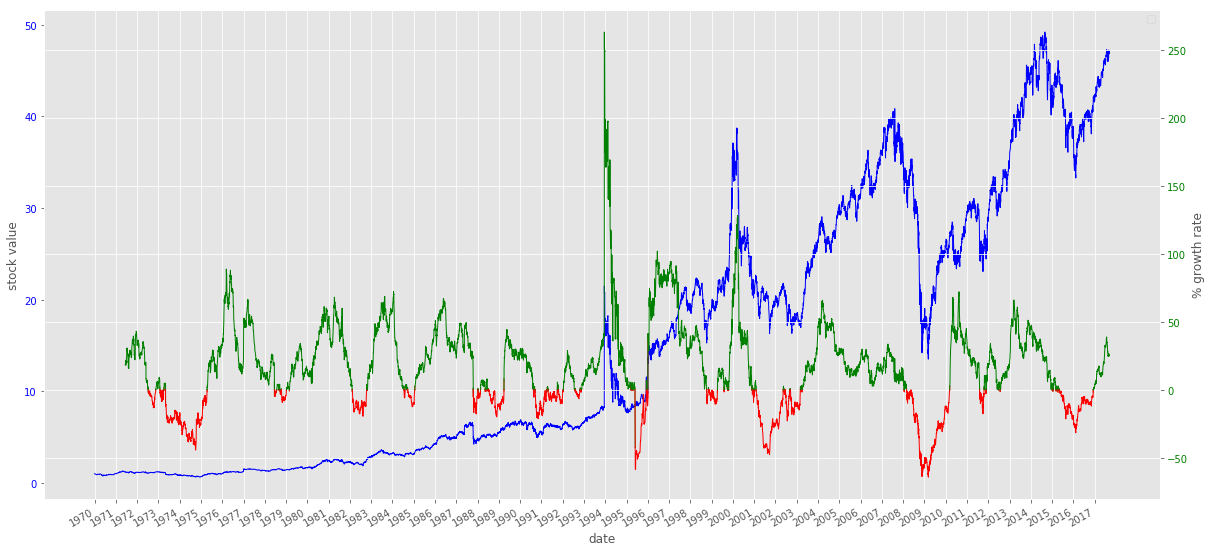

In [123]:
plot_growth_rate(allstockmean_dates, allstockmean, past_interval=365, smoothing_interval=10)

plot growth rate RE 6 months in past, with a little smoothing:

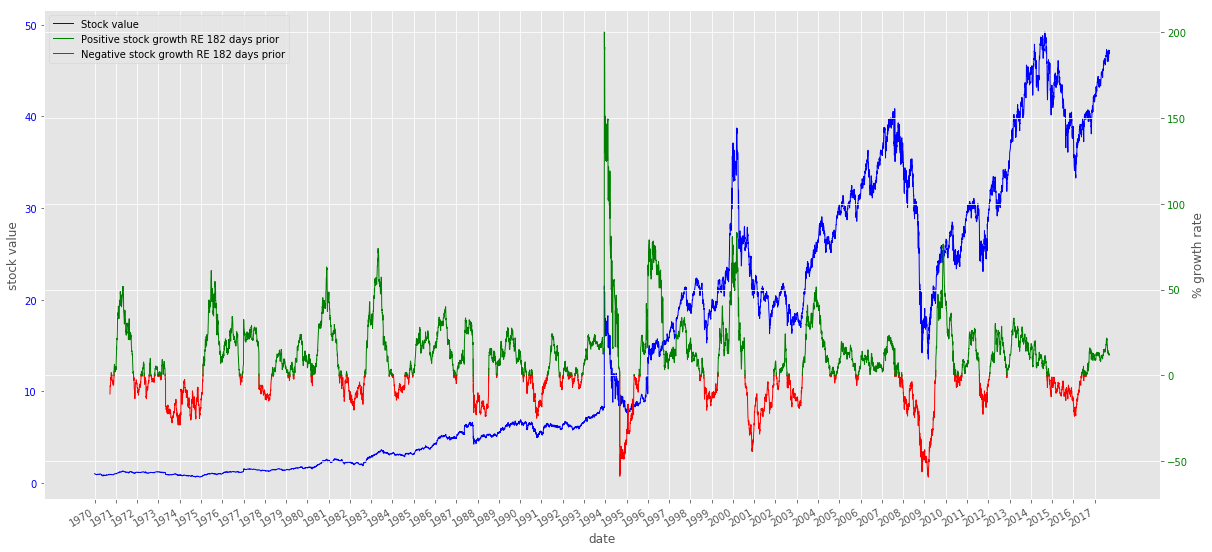

In [140]:
plot_growth_rate(allstockmean_dates, allstockmean, past_interval=182, smoothing_interval=10)

Plot growth rate from 2006 through 2009, past = 1 month, smoothing 5 days

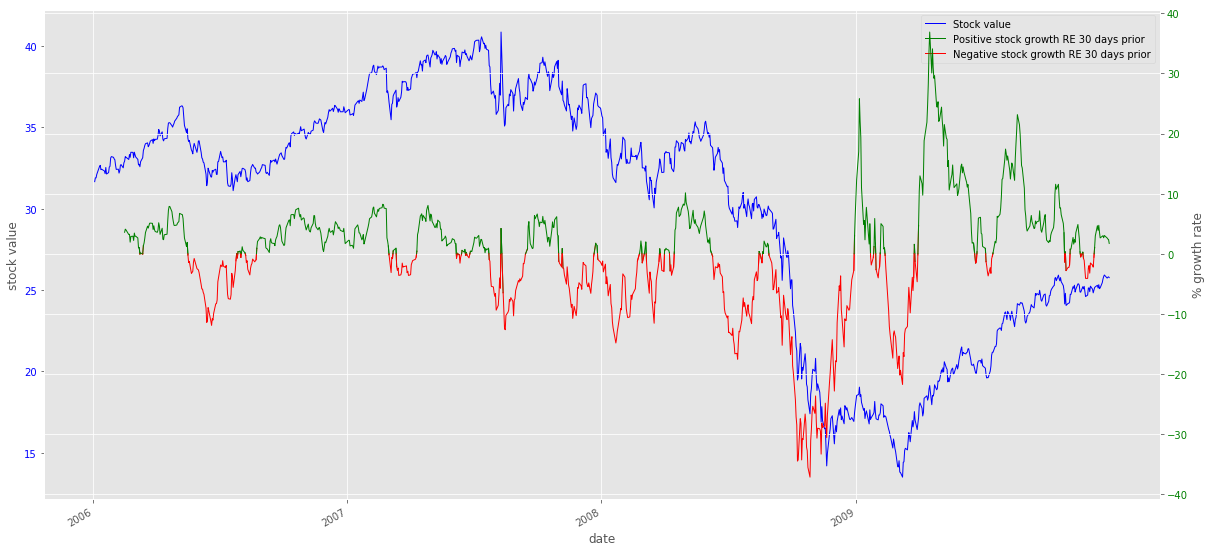

In [143]:
import datetime

startdate = datetime.date(2006, 1, 1) 
enddate = datetime.date(2010, 1, 1)

index = np.where(np.logical_and(allstockmean_dates>=pd.Timestamp(startdate), allstockmean_dates<=pd.Timestamp(enddate)))

plot_growth_rate(allstockmean_dates[index[0]], allstockmean[index[0]], past_interval=30, smoothing_interval=5)
